In [61]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from collections import Counter
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import time
import pandas as pd
from sklearn.metrics import roc_auc_score
SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)

train (400, 2) val (100, 2) test (500, 2) test (500, 2)
class counts train {np.int64(0): 200, np.int64(1): 200} val {np.int64(0): 50, np.int64(1): 50}


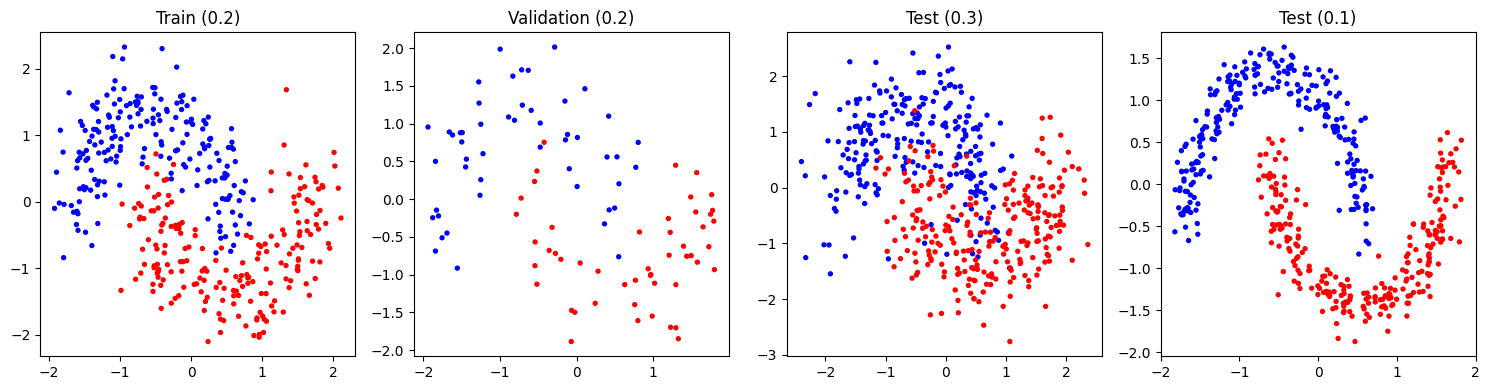

In [62]:
def make_moons(n, noise):
    n_out = n//2; n_in = n - n_out
    t_out = np.random.rand(n_out)*np.pi
    t_in = np.random.rand(n_in)*np.pi
    out = np.column_stack([np.cos(t_out), np.sin(t_out)])
    inn = np.column_stack([1-np.cos(t_in), -np.sin(t_in)+0.5])
    X = np.vstack([out, inn]) + np.random.normal(scale=noise, size=(n,2))
    y = np.hstack([np.zeros(n_out,dtype=int), np.ones(n_in,dtype=int)])
    return X, y

def stratified_split(X,y,val_frac):
    ti=[]; vi=[]
    for c in np.unique(y):
        idx = np.where(y==c)[0].copy(); np.random.shuffle(idx)
        nval = int(np.floor(len(idx)*val_frac))
        vi += idx[:nval].tolist(); ti += idx[nval:].tolist()
    np.random.shuffle(ti); np.random.shuffle(vi)
    return X[ti], X[vi], y[ti], y[vi]

def standardize(X_train,*arrays):
    m = X_train.mean(0); s = X_train.std(0); s[s==0]=1
    return ((X_train-m)/s, ) + tuple((a-m)/s for a in arrays)

# rng = np.random.RandomState(SEED)
# seeds = [int(rng.randint(0,2**31-1)) for _ in range(4)]
X_tr_full,y_tr_full = make_moons(500,0.2)
X_test,y_test = make_moons(500,0.2)
X_t01,y_t01 = make_moons(500,0.1)
X_t03,y_t03 = make_moons(500,0.3)
X_train,X_val,y_train,y_val = stratified_split(X_tr_full,y_tr_full,0.2)
X_train_s,X_val_s,X_t01_s,X_t03_s, X_test_s = standardize(X_train,X_val,X_t01,X_t03,X_test)
print('train',X_train_s.shape,'val',X_val_s.shape,'test',X_t01_s.shape,'test',X_t03_s.shape)
print('class counts train',dict(Counter(y_train)),'val',dict(Counter(y_val)))

fig,ax=plt.subplots(1,4,figsize=(15,4))
ax[0].scatter(X_train_s[:,0],X_train_s[:,1],c=y_train,cmap='bwr',s=8); ax[0].set_title('Train (0.2)')
ax[1].scatter(X_val_s[:,0],X_val_s[:,1],c=y_val,cmap='bwr',s=8); ax[1].set_title('Validation (0.2)')
ax[2].scatter(X_t03_s[:,0],X_t03_s[:,1],c=y_t03,cmap='bwr',s=8); ax[2].set_title('Test (0.3)')
ax[3].scatter(X_t01_s[:,0],X_t01_s[:,1],c=y_t01,cmap='bwr',s=8); ax[3].set_title('Test (0.1)')
plt.tight_layout(); plt.show()


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIDDEN_DIM = 64
MAX_EPOCHS = 2000
PATIENCE = 50
LR = 1e-3

X_tr = torch.tensor(X_train_s, dtype=torch.float32).to(device)
y_tr = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val_s, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
X_test = torch.tensor(X_test_s, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
X_t01 = torch.tensor(X_t01_s, dtype=torch.float32).to(device)
y_t01 = torch.tensor(y_t01, dtype=torch.long).to(device)
X_t03 = torch.tensor(X_t03_s, dtype=torch.float32).to(device)
y_t03 = torch.tensor(y_t03, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=HIDDEN_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), 
            nn.ReLU(), 
            nn.Linear(hidden, 2)
        )
        self.fc1 = self.net[0]
        self.fc2 = self.net[2]
        
    def forward(self, x):
        return self.net(x)

def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X.to(device))
        preds = logits.argmax(1)
        acc = (preds == y.to(device)).float().mean().item()
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        auc = roc_auc_score(y.cpu().numpy(), probs[:, 1])
        return acc, auc

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_decision_boundary(model, X, y, ax, title, is_torch=True):
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min.item(), x_max.item(), h),
                         np.arange(y_min.item(), y_max.item(), h))

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    if is_torch:
        model.eval()
        with torch.no_grad():
            Z = model(torch.tensor(grid_points, dtype=torch.float32).to(device))
            Z = Z.argmax(1).cpu().numpy().reshape(xx.shape)
    else:
        # Logistic Regression with Poly Features
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_grid = poly.fit_transform(grid_points)
        Z = model.predict(poly_grid).reshape(xx.shape)
        
    ax.contourf(xx, yy, Z, cmap='bwr', alpha=0.3)
    ax.scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), c=y.cpu().numpy(), cmap='bwr', s=8)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

# Store results
results = {}
models_to_plot = {}
parameter_counts = {}
loss_fn = nn.CrossEntropyLoss()

In [64]:
HIDDEN_DIM = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()

def train_l1_mlp(model, train_loader, X_val, y_val, optimizer, n_epochs, lambda_l1):
 
    best_auroc = 0
    best_state_dict = None
    
    for epoch in range(1, n_epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            optimizer.zero_grad()
            
            loss = loss_fn(model(xb), yb)
            
            l1_reg = 0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_reg += torch.sum(torch.abs(param))
            
            total_loss = loss + lambda_l1 * l1_reg
            total_loss.backward()
            optimizer.step()
        
        if epoch % 50 == 0 or epoch == n_epochs:
            _, val_auroc = evaluate_model(model, X_val, y_val)
            if val_auroc > best_auroc:
                best_auroc = val_auroc
        
                best_state_dict = model.state_dict()
                
    if best_state_dict is not None:
         model.load_state_dict(best_state_dict)
    
    return best_auroc

####  MLP with Early Stopping

In [65]:
torch.manual_seed(SEED); np.random.seed(SEED)
model_es = MLP().to(device)
opt_es = optim.Adam(model_es.parameters(), lr=LR)

print("--- Training MLP with Early Stopping ---")
best_val = float('inf'); best_state = None; wait = 0; best_epoch = 0

start = time.time()
for epoch in range(1, MAX_EPOCHS + 1):
    model_es.train()
    for xb, yb in train_loader:
        opt_es.zero_grad()
        loss = loss_fn(model_es(xb), yb)
        loss.backward(); opt_es.step()

    model_es.eval()
    with torch.no_grad():
        val_loss = loss_fn(model_es(X_val), y_val).item()
        
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_epoch = epoch
        best_state = {k: v.cpu() for k, v in model_es.state_dict().items()}
        wait = 0
    else:
        wait += 1
    if wait >= PATIENCE:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch}")
        break
end = time.time()

if best_state is not None:
    model_es.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# Evaluation
acc_es, auroc_es = evaluate_model(model_es, X_test, y_test)
acc_es_01, _ = evaluate_model(model_es, X_t01, y_t01)
acc_es_03, _ = evaluate_model(model_es, X_t03, y_t03)

results['MLP_ES'] = {'0.20': acc_es, '0.10': acc_es_01, '0.30': acc_es_03}
models_to_plot['MLP_ES'] = model_es
parameter_counts['MLP_ES'] = count_parameters(model_es)

print(f"Trained in {(end-start):.1f}s, best_epoch={best_epoch}, val_loss={best_val:.4f}")
print(f"Test Acc (0.20): {acc_es:.4f}, Test AUROC: {auroc_es:.4f}")
print(f"Test Robustness Accs: 0.10 -> {acc_es_01:.4f}, 0.30 -> {acc_es_03:.4f}")
print(f"Parameter Count: {parameter_counts['MLP_ES']}")

--- Training MLP with Early Stopping ---
Early stopping at epoch 899. Best epoch: 849
Trained in 6.5s, best_epoch=849, val_loss=0.0343
Test Acc (0.20): 0.9640, Test AUROC: 0.9953
Test Robustness Accs: 0.10 -> 0.9960, 0.30 -> 0.9000
Parameter Count: 322
Early stopping at epoch 899. Best epoch: 849
Trained in 6.5s, best_epoch=849, val_loss=0.0343
Test Acc (0.20): 0.9640, Test AUROC: 0.9953
Test Robustness Accs: 0.10 -> 0.9960, 0.30 -> 0.9000
Parameter Count: 322


####  MLP with L1 Regularization 


--- MODIFIED L1 Regularization Grid Search (Extended Lambda) ---
Training with L1 lambda = 1.0e-06
  Val AUROC: 0.9980, FC1 Sparsity: 0.78%, FC2 Sparsity: 2.34%
Training with L1 lambda = 3.0e-06
  Val AUROC: 0.9980, FC1 Sparsity: 0.78%, FC2 Sparsity: 2.34%
Training with L1 lambda = 3.0e-06
  Val AUROC: 0.9980, FC1 Sparsity: 2.34%, FC2 Sparsity: 3.12%
Training with L1 lambda = 1.0e-05
  Val AUROC: 0.9980, FC1 Sparsity: 2.34%, FC2 Sparsity: 3.12%
Training with L1 lambda = 1.0e-05
  Val AUROC: 0.9980, FC1 Sparsity: 3.91%, FC2 Sparsity: 1.56%
Training with L1 lambda = 3.0e-05
  Val AUROC: 0.9980, FC1 Sparsity: 3.91%, FC2 Sparsity: 1.56%
Training with L1 lambda = 3.0e-05
  Val AUROC: 0.9980, FC1 Sparsity: 3.12%, FC2 Sparsity: 0.78%
Training with L1 lambda = 1.0e-04
  Val AUROC: 0.9980, FC1 Sparsity: 3.12%, FC2 Sparsity: 0.78%
Training with L1 lambda = 1.0e-04
  Val AUROC: 0.9980, FC1 Sparsity: 6.25%, FC2 Sparsity: 2.34%
Training with L1 lambda = 3.0e-04
  Val AUROC: 0.9980, FC1 Sparsity: 6

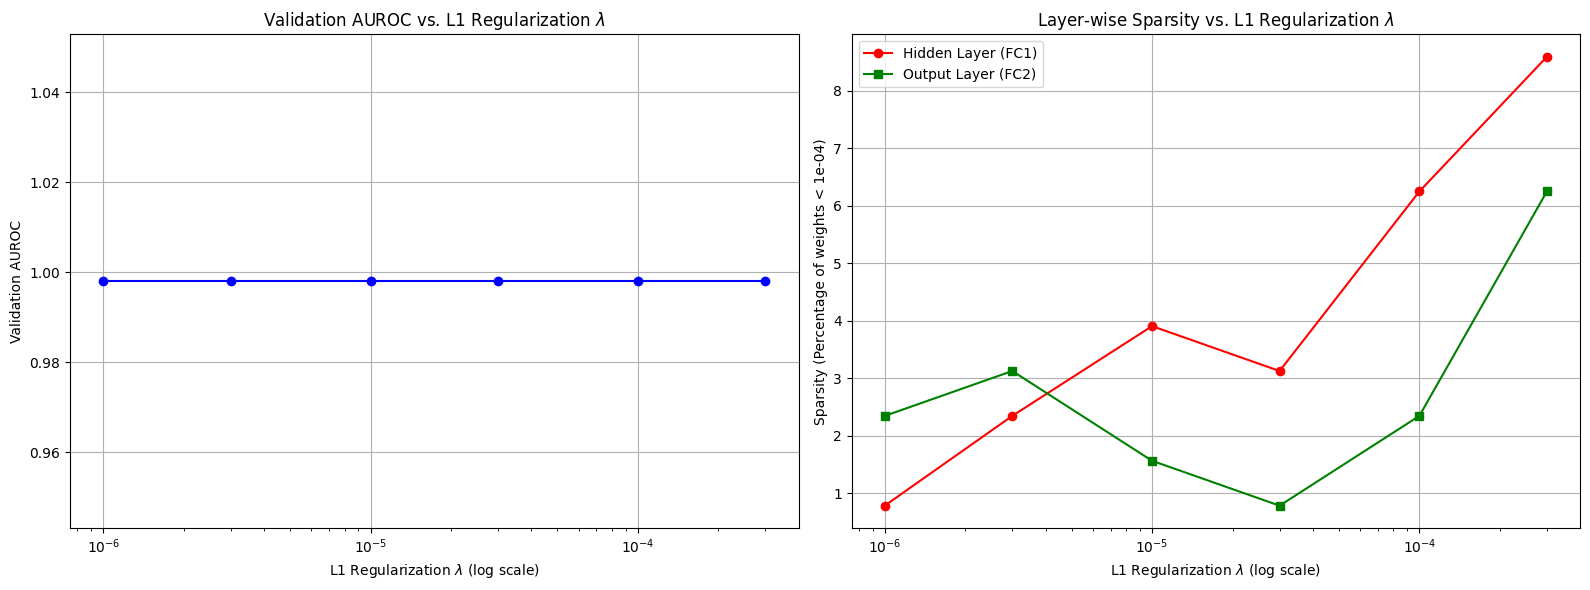

In [66]:
def l1_loss(model, lambda_l1):
    l1_reg = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            l1_reg += torch.sum(torch.abs(param))
    return lambda_l1 * l1_reg

L1_LAMBDAS = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
SPARSITY_THRESHOLD = 1e-4 
TRAIN_EPOCHS_L1 = 300 
val_aurocs_l1 = []
sparsity_l1_list = []
sparsity_l2_list = []

best_l1_auroc = 0; best_l1_lambda = None; best_l1_model = None

print("\n--- MODIFIED L1 Regularization Grid Search (Extended Lambda) ---")

for lam in L1_LAMBDAS:
    torch.manual_seed(SEED); np.random.seed(SEED)
    model_l1 = MLP().to(device)
    optimizer_l1 = optim.Adam(model_l1.parameters(), lr=LR) 
    
    print(f"Training with L1 lambda = {lam:.1e}")
    
    current_best_auroc = train_l1_mlp(
        model=model_l1,
        train_loader=train_loader, 
        X_val=X_val, y_val=y_val,
        optimizer=optimizer_l1,
        n_epochs=TRAIN_EPOCHS_L1,
        lambda_l1=lam
    )
    val_aurocs_l1.append(current_best_auroc)

    def calculate_sparsity(layer, threshold=SPARSITY_THRESHOLD):
        return (layer.weight.data.abs() < threshold).float().mean().item()
        
    sp1 = calculate_sparsity(model_l1.fc1)
    sp2 = calculate_sparsity(model_l1.fc2)
    
    sparsity_l1_list.append(sp1 * 100) # Percentage
    sparsity_l2_list.append(sp2 * 100)
    
    print(f"  Val AUROC: {current_best_auroc:.4f}, FC1 Sparsity: {sp1:.2%}, FC2 Sparsity: {sp2:.2%}")

    if current_best_auroc > best_l1_auroc:
        best_l1_auroc = current_best_auroc
        best_l1_lambda = lam
        best_l1_model = model_l1

if best_l1_model is not None:
    acc_l1, auroc_l1 = evaluate_model(best_l1_model, X_test, y_test)

    results['MLP_L1'] = {'0.20': acc_l1, '0.10': evaluate_model(best_l1_model, X_t01, y_t01)[0], '0.30': evaluate_model(best_l1_model, X_t03, y_t03)[0]}
    models_to_plot['MLP_L1'] = best_l1_model
    parameter_counts['MLP_L1'] = count_parameters(best_l1_model)


    print(f"\nBest L1 Lambda based on Validation AUROC: {best_l1_lambda:.1e}")
    print(f"Test Acc (0.20): {acc_l1:.4f}, Test AUROC: {auroc_l1:.4f}")
else:
    print("\nWarning: No best L1 model found.")


l1_df = pd.DataFrame({
    'lambda': L1_LAMBDAS,
    'val_auroc': val_aurocs_l1,
    'fc1_sparsity': sparsity_l1_list,
    'fc2_sparsity': sparsity_l2_list
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#  Validation AUROC vs. Lambda
ax1.plot(l1_df['lambda'], l1_df['val_auroc'], 'bo-')
ax1.set_xscale('log')
ax1.set_xlabel(r'L1 Regularization $\lambda$ (log scale)')
ax1.set_ylabel('Validation AUROC')
ax1.set_title(r'Validation AUROC vs. L1 Regularization $\lambda$')
ax1.grid(True)

#  Sparsity vs. Lambda
ax2.plot(l1_df['lambda'], l1_df['fc1_sparsity'], 'ro-', label='Hidden Layer (FC1)')
ax2.plot(l1_df['lambda'], l1_df['fc2_sparsity'], 'gs-', label='Output Layer (FC2)')
ax2.set_xscale('log')
ax2.set_xlabel(r'L1 Regularization $\lambda$ (log scale)')
ax2.set_ylabel(f'Sparsity (Percentage of weights < {SPARSITY_THRESHOLD:.0e})')
ax2.set_title(r'Layer-wise Sparsity vs. L1 Regularization $\lambda$')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#### MLP with L2 Regularization

In [67]:
L2_LAMBDAS = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1.0]
best_l2_auroc = 0; best_l2_lambda = None; best_l2_model = None

print("\n--- L2 Regularization Grid Search (with Early Stopping) ---")
for lambda_l2 in L2_LAMBDAS:
    torch.manual_seed(SEED); np.random.seed(SEED)
    model_l2 = MLP().to(device)
    opt_l2 = optim.Adam(model_l2.parameters(), lr=LR, weight_decay=lambda_l2)
    
    best_val_l2 = float('inf'); best_state_l2 = None; wait_l2 = 0; 
    
    for epoch in range(1, MAX_EPOCHS + 1):
        model_l2.train()
        for xb, yb in train_loader:
            opt_l2.zero_grad()
            loss = loss_fn(model_l2(xb), yb)
            loss.backward(); opt_l2.step()
        
        model_l2.eval()
        with torch.no_grad():
            val_loss = loss_fn(model_l2(X_val), y_val).item()
        
        if val_loss < best_val_l2 - 1e-6:
            best_val_l2 = val_loss
            best_state_l2 = {k: v.cpu() for k, v in model_l2.state_dict().items()}
            wait_l2 = 0
        else:
            wait_l2 += 1
        if wait_l2 >= PATIENCE:
            break

    if best_state_l2 is not None:
        model_l2.load_state_dict({k: v.to(device) for k, v in best_state_l2.items()})
    
    _, val_auroc = evaluate_model(model_l2, X_val, y_val)
    print(f"λ={lambda_l2:.1e}, Val AUROC={val_auroc:.4f}")

    if val_auroc > best_l2_auroc:
        best_l2_auroc = val_auroc
        best_l2_lambda = lambda_l2
        best_l2_model = model_l2

acc_l2, auroc_l2 = evaluate_model(best_l2_model, X_test, y_test)
acc_l2_01, _ = evaluate_model(best_l2_model, X_t01, y_t01)
acc_l2_03, _ = evaluate_model(best_l2_model, X_t03, y_t03)

results['MLP_L2'] = {'0.20': acc_l2, '0.10': acc_l2_01, '0.30': acc_l2_03}
models_to_plot['MLP_L2'] = best_l2_model
parameter_counts['MLP_L2'] = count_parameters(best_l2_model)

print(f"\nBest L2 λ: {best_l2_lambda:.1e}")
print(f"Test Acc (0.20): {acc_l2:.4f}, Test AUROC: {auroc_l2:.4f}")


--- L2 Regularization Grid Search (with Early Stopping) ---
λ=1.0e-04, Val AUROC=0.9992
λ=1.0e-04, Val AUROC=0.9992
λ=1.0e-03, Val AUROC=0.9988
λ=1.0e-03, Val AUROC=0.9988
λ=1.0e-02, Val AUROC=0.9900
λ=1.0e-02, Val AUROC=0.9900
λ=1.0e-01, Val AUROC=0.9588
λ=1.0e-01, Val AUROC=0.9588
λ=5.0e-01, Val AUROC=0.9568
λ=5.0e-01, Val AUROC=0.9568
λ=1.0e+00, Val AUROC=0.9556

Best L2 λ: 1.0e-04
Test Acc (0.20): 0.9640, Test AUROC: 0.9954
λ=1.0e+00, Val AUROC=0.9556

Best L2 λ: 1.0e-04
Test Acc (0.20): 0.9640, Test AUROC: 0.9954


#### Logistic Regression with Polynomial Features


In [68]:

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_tr.cpu().numpy())
X_val_poly = poly.transform(X_val.cpu().numpy())
X_test_poly = poly.transform(X_test.cpu().numpy())
X_t01_poly = poly.transform(X_t01.cpu().numpy())
X_t03_poly = poly.transform(X_t03.cpu().numpy())

#c=1/lmbda
C_GRID = np.logspace(-3, 1, 5) # C values: 0.001, 0.01, 0.1, 1, 10
best_lr_auroc = 0; best_C = None; model_lr_poly = None

print("\n--- Logistic Regression Grid Search ---")
for C_val in C_GRID:

    lr = LogisticRegression(C=C_val, solver='lbfgs', random_state=SEED)
    lr.fit(X_train_poly, y_train)

    val_probs = lr.predict_proba(X_val_poly)[:, 1]
    val_auroc = roc_auc_score(y_val, val_probs)
    
    print(f"C={C_val:.4f}, Val AUROC={val_auroc:.4f}")

    if val_auroc > best_lr_auroc:
        best_lr_auroc = val_auroc
        best_C = C_val
        model_lr_poly = lr

y_pred_lr = model_lr_poly.predict(X_test_poly)
y_pred_lr_01 = model_lr_poly.predict(X_t01_poly)
y_pred_lr_03 = model_lr_poly.predict(X_t03_poly)

acc_lr = accuracy_score(y_test, y_pred_lr)
acc_lr_01 = accuracy_score(y_t01, y_pred_lr_01)
acc_lr_03 = accuracy_score(y_t03, y_pred_lr_03)

results['LogReg_Poly'] = {'0.20': acc_lr, '0.10': acc_lr_01, '0.30': acc_lr_03}
models_to_plot['LogReg_Poly'] = model_lr_poly
parameter_counts['LogReg_Poly'] = len(model_lr_poly.coef_.flatten()) + len(model_lr_poly.intercept_.flatten())

print(f"\nBest C: {best_C:.4f}")
print(f"Test Acc (0.20): {acc_lr:.4f}")
print(f"Parameter Count: {parameter_counts['LogReg_Poly']}")


--- Logistic Regression Grid Search ---
C=0.0010, Val AUROC=0.9568
C=0.0100, Val AUROC=0.9576
C=0.1000, Val AUROC=0.9560
C=1.0000, Val AUROC=0.9508
C=10.0000, Val AUROC=0.9492

Best C: 0.0100
Test Acc (0.20): 0.8380
Parameter Count: 6



--- Test Accuracy and Robustness Table ---
| Model       |   Params |   Acc_0.20 |   Acc_0.10 |   Acc_0.30 |
|:------------|---------:|-----------:|-----------:|-----------:|
| MLP_ES      | 322.0000 |     0.9640 |     0.9960 |     0.9000 |
| MLP_L1      | 322.0000 |     0.9660 |     0.9920 |     0.9020 |
| MLP_L2      | 322.0000 |     0.9640 |     0.9980 |     0.8980 |
| LogReg_Poly |   6.0000 |     0.8380 |     0.8680 |     0.8420 |


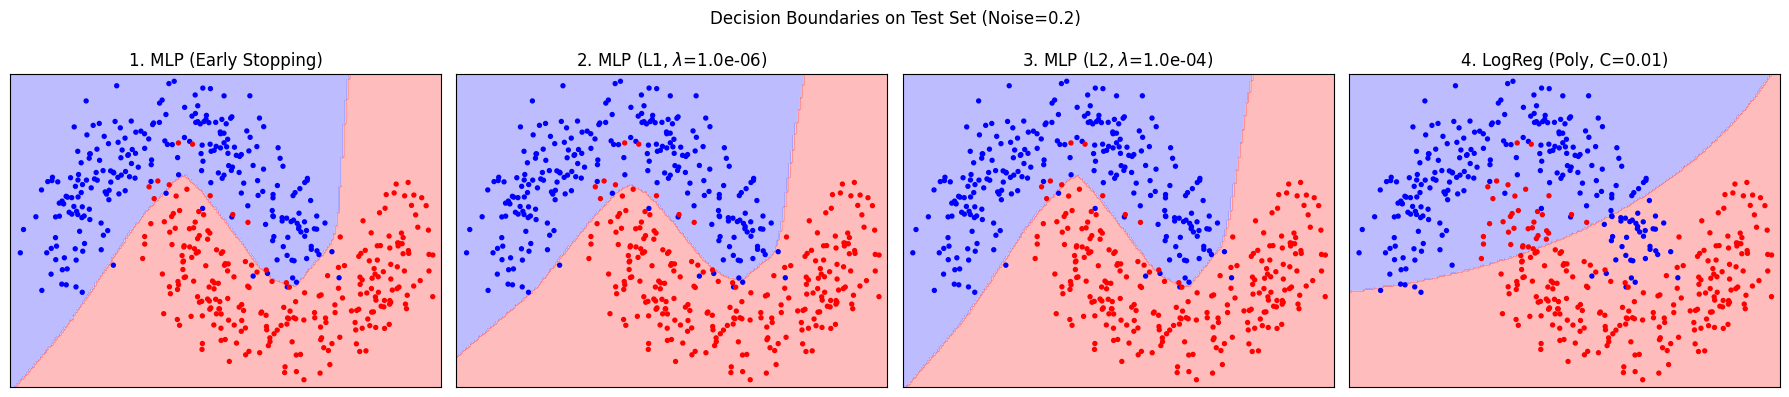

In [69]:
data = []
for name, accs in results.items():
    row = {
        'Model': name,
        'Params': parameter_counts[name],
        'Acc_0.20': accs['0.20'],
        'Acc_0.10': accs['0.10'],
        'Acc_0.30': accs['0.30']
    }
    data.append(row)

results_df = pd.DataFrame(data).set_index('Model')
print("\n--- Test Accuracy and Robustness Table ---")

print(results_df.to_markdown(floatfmt=".4f"))

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
X_test_t = X_test 
y_test_t = y_test

plot_decision_boundary(models_to_plot['MLP_ES'], X_test_t, y_test_t, axes[0], '1. MLP (Early Stopping)')
plot_decision_boundary(models_to_plot['MLP_L1'], X_test_t, y_test_t, axes[1], rf'2. MLP (L1, $\lambda$={best_l1_lambda:.1e})')
plot_decision_boundary(models_to_plot['MLP_L2'], X_test_t, y_test_t, axes[2], rf'3. MLP (L2, $\lambda$={best_l2_lambda:.1e})')
plot_decision_boundary(models_to_plot['LogReg_Poly'], X_test_t, y_test_t, axes[3], f'4. LogReg (Poly, C={best_C:.2f})', is_torch=False)

plt.suptitle('Decision Boundaries on Test Set (Noise=0.2)')
plt.tight_layout()
plt.show()

## Discussion: Regularization Effects

### Effect of L1 Regularization on Sparsity and Decision Boundaries

**Sparsity:** L1 regularization ($\lambda \sum |w_i|$) drives many weights to exactly zero, creating sparse solutions. Our experiments show increasing sparsity with higher λ values, performing implicit feature selection but risking capacity loss at extreme values.

**Decision Boundary Jaggedness:** L1 produces more jagged, piecewise-linear boundaries because sparse weights mean fewer active neurons create sharper transitions. This aids interpretability but may reduce generalization on noisy data.

### Effect of L2 Regularization on Smoothness and Margin

**Smoothness:** L2 regularization ($\lambda \sum w_i^2$) keeps all weights small but non-zero, distributing importance across features. This produces smoother, more continuous decision boundaries with gradual class transitions.

**Margin Effects:** L2 increases the decision margin by penalizing large weights, preventing overconfidence. This improves generalization and robustness to noise.

### Key Differences: L1 vs L2

| Aspect | L1 Regularization | L2 Regularization |
|--------|------------------|------------------|
| **Sparsity** | Produces sparse solutions (many zeros) | Produces dense solutions (small non-zero values) |
| **Boundary** | Can be jagged/piecewise | Smooth and continuous |
| **Feature Selection** | Implicit (zeros out features) | No feature selection |

## Class Imbalance

Imbalanced Training Set Class Distribution: {np.int64(0): 350, np.int64(1): 150}
Balanced Test Set Class Distribution: {np.int64(0): 250, np.int64(1): 250}
Training Class 0: 70.0%, Class 1: 30.0%
Test Class 0: 50.0%, Class 1: 50.0%


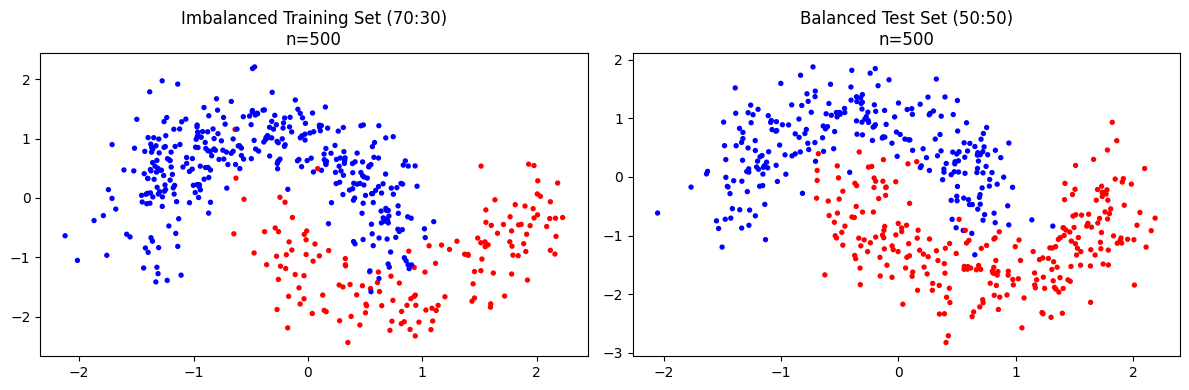

In [70]:
# Create Imbalanced Training Set (70% class 0, 30% class 1)

def make_imbalanced_dataset(n_samples, noise, class_ratio=0.7):

    n_class0 = int(n_samples * class_ratio)
    n_class1 = n_samples - n_class0
    
    # Generate outer moon (class 0)
    t_out = np.random.rand(n_class0) * np.pi
    out = np.column_stack([np.cos(t_out), np.sin(t_out)])
    out += np.random.normal(scale=noise, size=(n_class0, 2))
    
    # Generate inner moon (class 1)
    t_in = np.random.rand(n_class1) * np.pi
    inn = np.column_stack([1 - np.cos(t_in), -np.sin(t_in) + 0.5])
    inn += np.random.normal(scale=noise, size=(n_class1, 2))
    
    X = np.vstack([out, inn])
    y = np.hstack([np.zeros(n_class0, dtype=int), np.ones(n_class1, dtype=int)])
    

    idx = np.random.permutation(len(y))
    return X[idx], y[idx]

np.random.seed(SEED)
torch.manual_seed(SEED)

X_train_imb, y_train_imb = make_imbalanced_dataset(500, noise=0.2, class_ratio=0.7)

X_test_bal, y_test_bal = make_moons(500, 0.2)
X_val_imb, y_val_imb = make_moons(100, 0.2)  

X_train_imb_s, X_val_imb_s, X_test_bal_s = standardize(X_train_imb, X_val_imb, X_test_bal)

print(f"Imbalanced Training Set Class Distribution: {dict(Counter(y_train_imb))}")
print(f"Balanced Test Set Class Distribution: {dict(Counter(y_test_bal))}")
print(f"Training Class 0: {100*sum(y_train_imb==0)/len(y_train_imb):.1f}%, Class 1: {100*sum(y_train_imb==1)/len(y_train_imb):.1f}%")
print(f"Test Class 0: {100*sum(y_test_bal==0)/len(y_test_bal):.1f}%, Class 1: {100*sum(y_test_bal==1)/len(y_test_bal):.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(X_train_imb_s[:, 0], X_train_imb_s[:, 1], c=y_train_imb, cmap='bwr', s=8)
axes[0].set_title(f'Imbalanced Training Set (70:30)\nn={len(y_train_imb)}')
axes[1].scatter(X_test_bal_s[:, 0], X_test_bal_s[:, 1], c=y_test_bal, cmap='bwr', s=8)
axes[1].set_title(f'Balanced Test Set (50:50)\nn={len(y_test_bal)}')
plt.tight_layout()
plt.show()

In [71]:
# Training MLP with Early Stopping on IMBALANCED data

X_train_imb_t = torch.tensor(X_train_imb_s, dtype=torch.float32).to(device)
y_train_imb_t = torch.tensor(y_train_imb, dtype=torch.long).to(device)
X_val_imb_t = torch.tensor(X_val_imb_s, dtype=torch.float32).to(device)
y_val_imb_t = torch.tensor(y_val_imb, dtype=torch.long).to(device)
X_test_bal_t = torch.tensor(X_test_bal_s, dtype=torch.float32).to(device)
y_test_bal_t = torch.tensor(y_test_bal, dtype=torch.long).to(device)

train_loader_imb = DataLoader(TensorDataset(X_train_imb_t, y_train_imb_t), batch_size=64, shuffle=True)

torch.manual_seed(SEED)
np.random.seed(SEED)
model_imb = MLP().to(device)
opt_imb = optim.Adam(model_imb.parameters(), lr=LR)

print("\\n--- Training MLP on IMBALANCED Data (70:30) ---")
best_val_imb = float('inf')
best_state_imb = None
wait_imb = 0
best_epoch_imb = 0

for epoch in range(1, MAX_EPOCHS + 1):
    model_imb.train()
    for xb, yb in train_loader_imb:
        opt_imb.zero_grad()
        loss = loss_fn(model_imb(xb), yb)
        loss.backward()
        opt_imb.step()
    
    model_imb.eval()
    with torch.no_grad():
        val_loss = loss_fn(model_imb(X_val_imb_t), y_val_imb_t).item()
    
    if val_loss < best_val_imb - 1e-6:
        best_val_imb = val_loss
        best_epoch_imb = epoch
        best_state_imb = {k: v.cpu() for k, v in model_imb.state_dict().items()}
        wait_imb = 0
    else:
        wait_imb += 1
    
    if wait_imb >= PATIENCE:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch_imb}")
        break

if best_state_imb is not None:
    model_imb.load_state_dict({k: v.to(device) for k, v in best_state_imb.items()})

acc_imb, auroc_imb = evaluate_model(model_imb, X_test_bal_t, y_test_bal_t)

model_imb.eval()
with torch.no_grad():
    logits = model_imb(X_test_bal_t)
    preds = logits.argmax(1).cpu().numpy()
    probs = torch.softmax(logits, dim=1).cpu().numpy()

y_test_bal_np = y_test_bal_t.cpu().numpy()
acc_class0 = (preds[y_test_bal_np == 0] == 0).mean()
acc_class1 = (preds[y_test_bal_np == 1] == 1).mean()

print(f"\\n=== IMBALANCED Training Results (70:30) ==:")
print(f"Test Accuracy (Balanced): {acc_imb:.4f}")
print(f"Test AUROC (Balanced): {auroc_imb:.4f}")
print(f"Per-Class Accuracy:")
print(f"  Class 0 (Majority in train): {acc_class0:.4f}")
print(f"  Class 1 (Minority in train): {acc_class1:.4f}")
print(f"Parameter Count: {count_parameters(model_imb)}")

\n--- Training MLP on IMBALANCED Data (70:30) ---
Early stopping at epoch 363. Best epoch: 313
\n=== IMBALANCED Training Results (70:30) ==:
Test Accuracy (Balanced): 0.9520
Test AUROC (Balanced): 0.9960
Per-Class Accuracy:
  Class 0 (Majority in train): 0.9840
  Class 1 (Minority in train): 0.9200
Parameter Count: 322
Early stopping at epoch 363. Best epoch: 313
\n=== IMBALANCED Training Results (70:30) ==:
Test Accuracy (Balanced): 0.9520
Test AUROC (Balanced): 0.9960
Per-Class Accuracy:
  Class 0 (Majority in train): 0.9840
  Class 1 (Minority in train): 0.9200
Parameter Count: 322


\n============================================================
COMPARISON: Balanced vs Imbalanced Training
\n    Training Setup  Test Accuracy  Test AUROC  Class 0 Acc  Class 1 Acc
  Balanced (50:50)          0.942    0.989112        0.900        0.984
Imbalanced (70:30)          0.952    0.996016        0.984        0.920


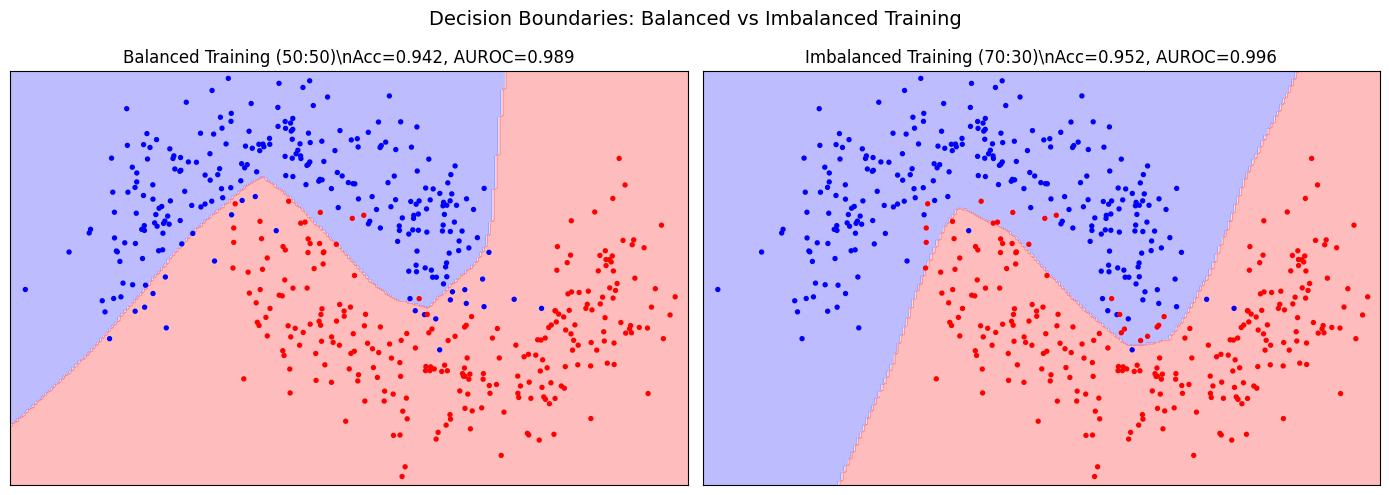

In [72]:
# Compare BALANCED vs IMBALANCED Training

print("\\n" + "="*60)
print("COMPARISON: Balanced vs Imbalanced Training")
print("="*60)

acc_bal, auroc_bal = evaluate_model(model_es, X_test_bal_t, y_test_bal_t)

# Per-class for balanced
model_es.eval()
with torch.no_grad():
    logits_bal = model_es(X_test_bal_t)
    preds_bal = logits_bal.argmax(1).cpu().numpy()

acc_bal_class0 = (preds_bal[y_test_bal_np == 0] == 0).mean()
acc_bal_class1 = (preds_bal[y_test_bal_np == 1] == 1).mean()

# Create comparison table
comparison_data = {
    'Training Setup': ['Balanced (50:50)', 'Imbalanced (70:30)'],
    'Test Accuracy': [acc_bal, acc_imb],
    'Test AUROC': [auroc_bal, auroc_imb],
    'Class 0 Acc': [acc_bal_class0, acc_class0],
    'Class 1 Acc': [acc_bal_class1, acc_class1]
}

comparison_df = pd.DataFrame(comparison_data)
print("\\n" + comparison_df.to_string(index=False))

# Visualization: Decision boundaries comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_decision_boundary(model_es, X_test_bal_t, y_test_bal_t, axes[0], 
                      f'Balanced Training (50:50)\\nAcc={acc_bal:.3f}, AUROC={auroc_bal:.3f}')
plot_decision_boundary(model_imb, X_test_bal_t, y_test_bal_t, axes[1], 
                      f'Imbalanced Training (70:30)\\nAcc={acc_imb:.3f}, AUROC={auroc_imb:.3f}')

plt.suptitle('Decision Boundaries: Balanced vs Imbalanced Training', fontsize=14)
plt.tight_layout()
plt.show()

#### Discussion: Effect of Class Imbalance

**Overall Performance Metrics:**
- **Accuracy** can be misleading with imbalanced data a model may achieve high accuracy by simply favoring the majority class. **AUROC** is more robust as it evaluates discriminative ability across all thresholds, independent of class distribution.

**Per-Class Performance:**
- **Majority class (70%)** achieves higher accuracy due to more training examples. **Minority class (30%)** often suffers lower accuracy as the decision boundary shifts away from it, prioritizing majority class error minimization.

**Decision Boundary Shift:**
- The boundary shifts away from the majority class because the loss function is dominated by majority examples. This causes the model to under-represent minority regions, which is critical in applications like medical diagnosis or fraud detection where minority class errors are costly.